# Pareto Frontiers for Adjoint Objective (Robustness & Control Trade-off)


## Imports

In [9]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();
# Pkg.develop(path="../../QuantumCollocation.jl")
using PiccoloQuantumObjects
using QuantumCollocation
using ForwardDiff
using LinearAlgebra
using Plots
using SparseArrays
using NamedTrajectories
using Statistics
using CairoMakie
using Random
using ColorSchemes
using Makie
using Printf

In [10]:
# Problem parameters
T = 25
Δt = 0.2
U_goal = GATES.H
H_drive = [PAULIS.X, PAULIS.Y, PAULIS.Z]
piccolo_opts = PiccoloOptions(verbose=false)
pretty_print(X::AbstractMatrix) = Base.show(stdout, "text/plain", X);
a_bound = 3.0
sys = QuantumSystem(H_drive)

∂ₑHₐ = [PAULIS.X, PAULIS.Y, PAULIS.Z]
var_sys = VariationalQuantumSystem(
    H_drive,
    ∂ₑHₐ
)


VariationalQuantumSystem: levels = 2, n_drives = 3

In [11]:
propertynames(sys.H)
sys.H.H_drift

2×2 SparseMatrixCSC{ComplexF64, Int64} with 0 stored entries:
     ⋅          ⋅    
     ⋅          ⋅    

In [12]:
function SpaceCurve(traj::NamedTrajectory, U_goal::AbstractMatrix{<:Number}, H_err::AbstractMatrix{<:Number})
    T = traj.T
    first_order_terms = Vector{Matrix{ComplexF64}}(undef, T)
    first_order_integral = zeros(ComplexF64, size(U_goal))

    for i in 1:T
        U = iso_vec_to_operator(traj.Ũ⃗[:, i])
        first_order_integral += U' * H_err * U
        first_order_terms[i] = first_order_integral
    end
    d = size(U_goal)[1]
    space_curve = [[real(tr(PAULIS.X * first_order_terms[t] / (d * T))),
                    real(tr(PAULIS.Y * first_order_terms[t] / (d * T))),
                    real(tr(PAULIS.Z * first_order_terms[t] / (d * T)))] for t in 1:T] 
    return space_curve
end

function space_curve_robustness(traj::NamedTrajectory, U_goal::AbstractMatrix, H_err::AbstractMatrix)
    curve = SpaceCurve(traj, U_goal, H_err)
    # Use the norm of the final point as a robustness measure
    # (larger values indicate more accumulated error sensitivity)
    final_point = curve[end]
    return norm(final_point)
end

function width_robustness(system::AbstractQuantumSystem, traj::NamedTrajectory; thresh::Float64=0.999)
    F = 1.0
    drift = system.H.H_drift
    drive = system.H.H_drives
    pauls = [PAULIS.X, PAULIS.Y, PAULIS.Z]
    widths = []
    for i in 1:3
        ε = 0.0
        err = pauls[i]
        F = 1.0
        while (ε < 0.5 && F >= thresh)
            noisy_drift = drift + ε * err
            noisy_sys = QuantumSystem(noisy_drift, drive)
            F = unitary_rollout_fidelity(traj, noisy_sys)
            ε += 0.0001
        end
        push!(widths, ε)
    end
    return widths
end

width_robustness (generic function with 1 method)

### Pareto Frontiers + Penalty Plots

In [13]:
ddas = 10 .^ range(0.0, 1.0, length=5)

5-element Vector{Float64}:
  1.0
  1.7782794100389228
  3.1622776601683795
  5.623413251903491
 10.0

In [14]:
n_guesses = 1
n_seeds = n_guesses
ddas = 10 .^ range(0.0, 1.0, length=16)
n_ddas = length(ddas)
init_var_probs = Matrix{Any}(undef, n_seeds, n_ddas)


# for i in 1:n_seeds
#     Random.seed!(1234+i)
#     for (j, dda) in enumerate(ddas)
#         var_prob = UnitaryVariationalProblem(
#             var_sys, U_goal, T, Δt;
#             piccolo_options=piccolo_opts,
#             a_bound=10.0,
#             dda_bound=dda,
#             Q_r=0.1,
#         )
#         takes = 1
#         fid = 0.0
#         while takes < 5 && fid < 0.999
#             solve!(var_prob; max_iter=20, print_level=1)
#             fid = unitary_rollout_fidelity(var_prob.trajectory, sys)
#             takes += 1
#         end
#         init_var_probs[i,j] = var_prob
#     end
# end



1×16 Matrix{Any}:
 #undef  #undef  #undef  #undef  #undef  …  #undef  #undef  #undef  #undef

In [15]:
# n_guesses = 1
# n_drives = sys.n_drives
# var_n_drives = var_sys.n_drives
# variational_scales = fill(1.0, length(var_sys.G_vars))
# seeds = []
# n_seeds = n_guesses
# n_ddas = length(ddas)

# uni_convergence_times = zeros(n_seeds, n_ddas)
# var_convergence_times = zeros(n_seeds, n_ddas)
# tog_convergence_times = zeros(n_seeds, n_ddas)

# ddas = 10 .^ range(-0.4, 0.4, length=20)


# default_probs = Matrix{Any}(undef, n_seeds, n_ddas)
# var_probs = Matrix{Any}(undef, n_seeds, n_ddas)
# tog_probs = Matrix{Any}(undef, n_seeds, n_ddas)
# uni_probs = Matrix{Any}(undef, n_seeds, n_ddas)
# # ftog_probs= Matrix{Any}(undef, n_seeds, n_ddas)

# Hₑ_add = a -> [PAULIS.X, PAULIS.Y, PAULIS.Z]
# F = 0.9999

# for i in 1:n_seeds
#     Random.seed!(124+20*i)
#     for (j, dda) in enumerate(ddas)

#         # uni problem
#         uni_prob = UnitaryUniversalProblem(
#             sys, U_goal, T, Δt;
#             piccolo_options=piccolo_opts,
#             activate_hyperspeed=true,
#             R=1e-5,
#             a_bound=Inf,
#             da_bound=Inf,
#             dda_bound=dda,
#             Q=0.0,
#             Q_t=1.0
#         )
#         push!(uni_prob.constraints, FinalUnitaryFidelityConstraint(U_goal, :Ũ⃗, F, uni_prob.trajectory))
#         uni_elapsed_time = @elapsed begin
#             solve!(uni_prob, max_iter=750, print_level=5, options=IpoptOptions(eval_hessian=false))
#             solve!(uni_prob, max_iter=40, print_level=5)
#         end
#         uni_convergence_times[i,j] = uni_elapsed_time
#         uni_probs[i,j] = uni_prob
#     end
# end


In [16]:
n_guesses = 1
n_drives = sys.n_drives

seeds = []
n_seeds = n_guesses


var_convergence_times = zeros(n_seeds, n_ddas)

default_probs = Matrix{Any}(undef, n_seeds, n_ddas)
var_probs = Matrix{Any}(undef, n_seeds, n_ddas)

Hₑ_add = a -> [PAULIS.X, PAULIS.Y, PAULIS.Z]
F = 0.999

for i in 1:n_seeds
    Random.seed!(124+20*i)
    for (j, dda) in enumerate(ddas)
       
        var_prob = UnitaryVariationalProblem(
            var_sys, U_goal, T, Δt;
            piccolo_options=piccolo_opts,
            Q=0.0,
            a_bound=10.0,
            dda_bound=dda,
            Q_r=1.0,
            # init_trajectory=deepcopy(init_var_probs[i, j].trajectory),
            # var_seed=false
        )
        push!(var_prob.constraints, FinalUnitaryFidelityConstraint(U_goal, :Ũ⃗, F, var_prob.trajectory))
        var_elapsed_time = @elapsed begin
            solve!(var_prob; max_iter=500, print_level=5, options=IpoptOptions(eval_hessian=false))
            solve!(var_prob; max_iter=25, print_level=5)
        end
        var_convergence_times[i,j] = var_elapsed_time
        var_probs[i, j] = var_prob
    end
end

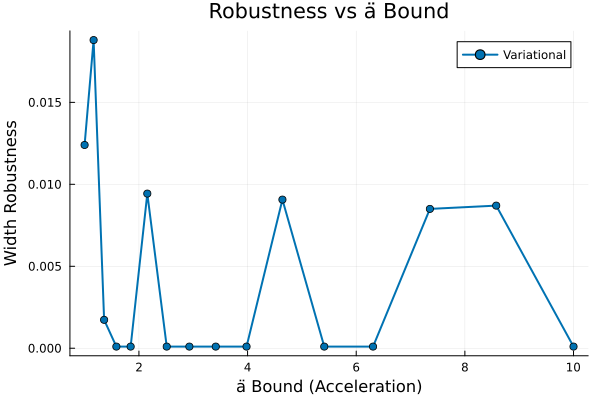

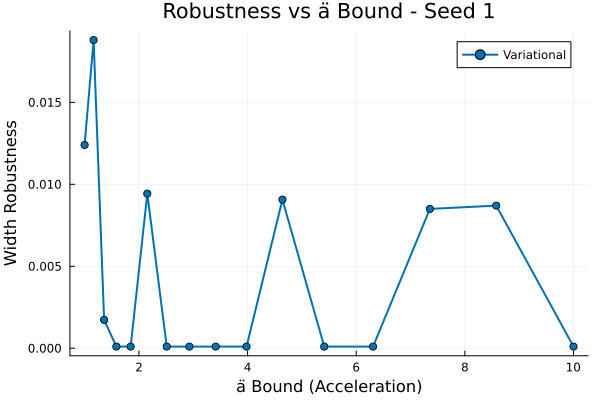

In [17]:
arr_probs = [var_probs]
method_names = ["Variational"]
method_colors = Makie.wong_colors()
ex_prob = var_probs[1,1]
dims = size(ex_prob.trajectory[:dda])

# Create the main plot
plt = Plots.plot(
    xlabel="ä Bound (Acceleration)",
    ylabel="Width Robustness",
    title="Robustness vs ä Bound",
    legend=:topright, 
    grid=true,
    linewidth=2,
    markersize=4
)

# Plot each method
for (prob_idx, probs) in enumerate(arr_probs)
    method_name = method_names[prob_idx]
    method_color = method_colors[prob_idx]
    
    # Average over seeds for each dda value
    avg_robustness_per_dda = Float64[]

    for (j, dda) in enumerate(ddas)
        seed_robustness = Float64[]

        for s in 1:n_seeds
            prob = probs[s, j]
            
            width = width_robustness(sys, prob.trajectory)
            avg_rob = mean(width)
            
            push!(seed_robustness, avg_rob)
        end
        
        # Average across seeds
        push!(avg_robustness_per_dda, mean(seed_robustness))

    end
    
    # Plot this method
    Plots.plot!(plt, ddas, avg_robustness_per_dda, 
               marker=:circle, 
               label=method_name, 
               color=method_color,
               linewidth=2,
               markersize=4)
end

display(plt)

# Optional: Create individual plots for each seed
for s in 1:n_seeds
    plt_seed = Plots.plot(
        xlabel="ä Bound (Acceleration)",
        ylabel="Width Robustness",
        title="Robustness vs ä Bound - Seed $s",
        legend=:topright, 
        grid=true,
        linewidth=2,
        markersize=4
    )
    
    for (prob_idx, probs) in enumerate(arr_probs)
        method_name = method_names[prob_idx]
        method_color = method_colors[prob_idx]
        
        robustness_per_dda = Float64[]
        for (j, dda) in enumerate(ddas)
            prob = probs[s, j]
            
            width = width_robustness(sys, prob.trajectory)
            avg_rob = mean(width)
            push!(robustness_per_dda, avg_rob)
        end
        
        
        Plots.plot!(plt_seed, ddas, robustness_per_dda, 
                   marker=:circle, 
                   label=method_name, 
                   color=method_color,
                   linewidth=2,
                   markersize=4)
    end
    
    display(plt_seed)
end

Initial Fidelity Summary Table

In [18]:
# for seed_idx in 1:n_seeds
#     display("\nseed idx = $seed_idx:")
#     display("Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Fast Toggle Fidelity | Universal Fidelity | ")
#     display("-" ^ 40)
#     for (j, ä) in enumerate(n_ddas)
#             def_fid = unitary_rollout_fidelity(default_probs[seed_idx, j].trajectory, sys)
#             var_fid = unitary_rollout_fidelity(var_probs[seed_idx, j].trajectory, sys)
#             tog_fid = unitary_rollout_fidelity(tog_probs[seed_idx, j].trajectory, sys)
#             ftog_fid = unitary_rollout_fidelity(ftog_probs[seed_idx, j].trajectory, sys)
#             uni_fid = unitary_rollout_fidelity(uni_probs[seed_idx, j].trajectory, sys)
#             display("$(lpad(round(ä, digits=6), 7)) | $(lpad(round(def_fid, digits=6), 12)) | $(lpad(round(var_fid, digits=6), 12)) | $(lpad(round(tog_fid, digits=6), 13))  | $(lpad(round(ftog_fid, digits=6), 13)) | $(lpad(round(uni_fid, digits=6), 13)) |")
#     end
# end

Pareto Frontiers

Penalty

In [19]:
sweep_rob_loss_λ = exp.(range(log(.1), log(100), length=8))


8-element Vector{Float64}:
   0.10000000000000002
   0.26826957952797265
   0.7196856730011523
   1.9306977288832508
   5.1794746792312125
  13.894954943731383
  37.27593720314942
 100.00000000000004

In [20]:
n_ddas = length(ddas)

pen_var_probs = Matrix{Any}(undef, n_seeds, n_ddas)
pvar_convergence_times = zeros(n_seeds, n_ddas)

Hₑ_add = a -> [PAULIS.X, PAULIS.Y, PAULIS.Z]
X_drive = sys.H.H_drives[1]
Hₑ_mult = a -> a[1] * X_drive
R_a=1e-2
R_da=1e-2

for i in 1:n_seeds
    Random.seed!(124+20*i)
    for (j, dda) in enumerate(ddas)
        # var problem
        var_prob = UnitaryVariationalProblem(
            var_sys, U_goal, T, Δt;
            piccolo_options=piccolo_opts,
            Q=0.0,
            a_bound=10.0,
            R_a=R_a,
            R_da=R_da,
            R_dda=10*dda,
            Q_r=1.0,
            # init_trajectory=deepcopy(init_var_probs[i, j].trajectory),
            # var_seed=false
        )
        push!(var_prob.constraints, FinalUnitaryFidelityConstraint(U_goal, :Ũ⃗, F, var_prob.trajectory))
        elapsed_time = @elapsed begin
            solve!(var_prob; max_iter=750, print_level=5, options=IpoptOptions(eval_hessian=false))
            solve!(var_prob; max_iter=20, print_level=5)
        end
        pen_var_probs[i, j] = var_prob
        pvar_convergence_times[i,j] = elapsed_time
    end
end

In [21]:
propertynames(var_probs[1, 1].trajectory[:dda])
var_probs[1, 1].trajectory[:dda]

3×25 view(reshape(view(::Vector{Float64}, :), 42, 25), 15:17, :) with eltype Float64:
 -0.223003     -0.323016    -0.34823     …   0.219727    5.72575e-19
 -0.000688287  -0.00275801  -0.00606581     -0.0019691  -2.57368e-18
 -0.219921     -0.317326    -0.34197         0.220171   -4.81113e-18

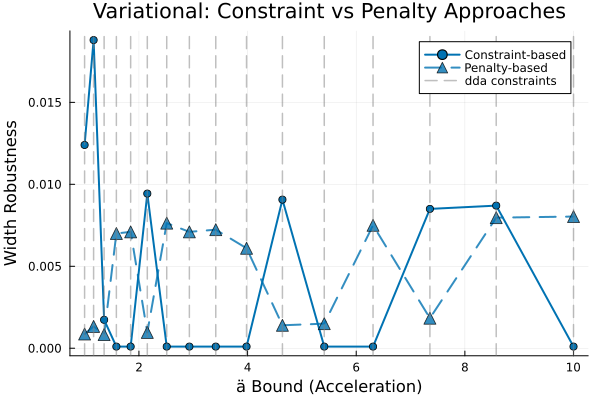

In [22]:
arr_probs = [var_probs]
pen_arr_probs = [pen_var_probs]
method_names = ["Variational"]
method_colors = Makie.wong_colors()
ex_prob = var_probs[1,1]
dims = size(ex_prob.trajectory[:dda])



# Create individual plots for each method showing both constraint and penalty approaches
for (method_idx, method_name) in enumerate(method_names)
    plt_method = Plots.plot(
        xlabel="ä Bound (Acceleration)",
        ylabel="Width Robustness",
        title="$method_name: Constraint vs Penalty Approaches",
        legend=:topright, 
        grid=true,
        linewidth=2,
        markersize=4
    )
    
    method_color = method_colors[method_idx]
    
    # Plot constraint-based approach
    probs = arr_probs[method_idx]
    avg_robustness_per_dda = Float64[]

    
    for (j, dda) in enumerate(ddas)
        seed_robustness = Float64[]

        for s in 1:n_seeds
            prob = probs[s, j]
            
            # Compute robustness using width curve for each Pauli direction
            
            width = width_robustness(sys, prob.trajectory)
            avg_rob = mean(width)
            push!(seed_robustness, avg_rob)         
        end
        
        # Average across seeds
        push!(avg_robustness_per_dda, mean(seed_robustness))
        
    end
    
    # Plot constraint approach
    Plots.plot!(plt_method, ddas, avg_robustness_per_dda, 
               marker=:circle, 
               label="Constraint-based", 
               color=method_color,
               linewidth=2,
               markersize=4)
    
    # Plot penalty-based approach
    pen_probs = pen_arr_probs[method_idx]
    penalty_x = Float64[]
    penalty_y = Float64[]
    
    for (j, dda) in enumerate(ddas)
        seed_robustness = Float64[]
        seed_penalty = Float64[]
        
        for s in 1:n_seeds
            prob = pen_probs[s, j]
            
            # Compute robustness using width curve for each Pauli direction
            
            width = width_robustness(sys, prob.trajectory)
            avg_rob = mean(width)
            push!(seed_robustness, avg_rob)         

            dda = mean(norm(prob.trajectory[:dda][:,dims[2]]))
            push!(seed_penalty, dda)
        end
        
        avg_robustness = mean(seed_robustness)
        
        # Effective acceleration Bound
        
        effective_accel_bound = mean(seed_penalty)
        
        push!(penalty_x, effective_accel_bound)
        push!(penalty_y, avg_robustness)
    end
    
    # Sort penalty points by x-axis for smooth line
    sort_idx = sortperm(penalty_x)
    penalty_x_sorted = penalty_x[sort_idx]
    penalty_y_sorted = penalty_y[sort_idx]
    
    # Plot penalty points as triangles with connecting line
    Plots.plot!(plt_method, ddas, penalty_y_sorted,
               marker=:utriangle,
               label="Penalty-based",
               color=method_color,
               linestyle=:dash,
               linewidth=2,
               markersize=6,
               alpha=0.8
               )

    y_limits = Plots.ylims(plt_method)
    for (j, dda_constraint) in enumerate(ddas)
        Plots.vline!(plt_method, [dda_constraint],
                    linestyle=:dash,
                    color=:gray,
                    alpha=0.5,
                    linewidth=1.5,
                    label=(j == 1 ? "dda constraints" : ""))
    end   
               
    display(plt_method)
end

### Save Traks

In [23]:
using JLD2
using Dates

# Collect trajectories only (lighter than storing whole problem objects)
var_trajs      = [var_probs[i, j].trajectory      for i in 1:n_seeds, j in 1:n_ddas]
# tog_trajs      = [tog_probs[i, j].trajectory      for i in 1:n_seeds, j in 1:n_ddas]
# uni_trajs      = [uni_probs[i, j].trajectory      for i in 1:n_seeds, j in 1:n_ddas]
# ftog_trajs     = [ftog_probs[i, j].trajectory     for i in 1:n_seeds, j in 1:n_ddas]

pen_var_trajs  = [pen_var_probs[i, j].trajectory  for i in 1:n_seeds, j in 1:n_ddas]
# pen_tog_trajs  = [pen_tog_probs[i, j].trajectory  for i in 1:n_seeds, j in 1:n_ddas]
# pen_uni_trajs  = [pen_uni_probs[i, j].trajectory  for i in 1:n_seeds, j in 1:n_ddas]
# pen_ftog_trajs = [pen_ftog_probs[i, j].trajectory for i in 1:n_seeds, j in 1:ddas]

# Minimal metadata to reconstruct the setup
meta = Dict(
    "T" => T,
    "Δt" => Δt,
    "U_goal" => U_goal,
    "n_seeds" => n_seeds,
    "n_ddas" => n_ddas,
    "ddas" => ddas,
    "F" => F,
    "n_drives" => n_drives,
)

# Make an artifacts/ folder and generate a timestamped filename
mkpath("artifacts")
timestamp = Dates.format(Dates.now(), "yyyymmdd_HHMMSS")
outfile = joinpath("artifacts", "trajectories_$(timestamp).jld2")

@info "Saving trajectories to $outfile"
@save outfile var_trajs pen_var_trajs meta
@info "Done. Saved keys: var_trajs, pen_var_trajs, meta"

To load the data for later, use:

In [24]:
# using JLD2
# @load "artifacts/trajectories_YYYYMMDD_HHMMSS.jld2" default_trajs, final_var_probs, final_tog_probs, final_uni_probs, pen_var_probs, pen_tog_probs, pen_uni_probs, meta
